# D - Isotope Combinations

Objective
-
The purpose of this notebook is to reconcile the information we have developed thus far with the naturally occuring amounts of each isotope in each detector material. This notebook computes the flux-convolved recoil energy spectrum for detector materials made of naturally occurring isotopes, specifically Silicon (Si). Since natural materials consist of multiple isotopes with known abundances, we need to combine the recoil spectra for each isotope into a single, weighted average spectrum. We will:
- Calculate how likely neutrons are to scatter off nuclei of each isotope.
- Weight each isotope’s contribution based on its natural abundance.
- Sum everything to get the total recoil energy distribution expected in the detector.

Natural silicon has three isotopes and corresponding concentrations:
- Silicon-28 - 92.22%
- Silicon-30 - 4.69%
- Silicon-31 - 3.09%

Values taken from [National Isotope Development Center - Silicon][National Isotope Development Center - Silicon]

[National Isotope Development Center - Silicon]: https://www.isotopes.gov/products/silicon "NIDC - Silicon Documentaion"

Libraries and Style Files
-------------------------

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles

# Extend Python path to include local module directory
import sys
sys.path.append('../python/')

# Install packages if not already available
import importlib.util
import subprocess

def install_if_missing(pkg):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("periodictable")
install_if_missing("pyteomics")

# Standard scientific libraries
# Standard scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as co
from scipy import integrate
from scipy.interpolate import interp1d
from functools import lru_cache  # NEW: for speeding up repeated calls

# Project-specific modules
import flux_recoil_spec as frs
from flux_recoil_spec import endfel

We will now encode the isotopic values for Silicon and Germanium in Python:

In [2]:
# Natural abundances of silicon isotopes (in fractional form)
si_isotopes = {
    28: 0.9222,
    29: 0.0464,
    30: 0.0309
}

Define Flux Interpolator
-
We will now load neutron energy `E_flux`, in MeV) and flux `F_flux`, in n/cm²/s/MeV) from the SNOLAB environment. Then, we will create a smooth, continuous function `realflux(En)` that returns neutron flux at any energy `En` using interpolation.

In [3]:
# Load energy (E_flux, in MeV) and flux (F_flux, in n/cm²/s/MeV) from SNOLAB neutron flux data
E_flux, F_flux, *_ = frs.SNOLAB_flux()

# Create an interpolator for continuous access to flux
flux_interp = interp1d(E_flux, F_flux, bounds_error=False, fill_value=0.0)

# Wrapper for the interpolated flux function.
def realflux(En):
    return flux_interp(En)

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017016933, intercept=-12.883178144228596, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.01482451947661301, intercept_stderr=0.06273875262265731)
0.009998654133395216 0.01


Compute Recoil Spectrum for Each Isotope
-
We being this section by computing the differential cross section $\frac{d\sigma}{dE_r}$ (cm²/keV) for neutron elastic scattering on a nucleus of mass number A, using data from ENDF6 with the following parameters:
- `En`: incident neutron energy in keV
- `Er`: recoil energy in keV
- `A`: target nucleus mass number (e.g., 28 for Si-28)

The function returns $\frac{d\sigma}{dE_r}$ in cm²/keV.

From the equation
$$
E_r=2fE_n(1-cos\theta)
$$

We solve for $cos\theta$ to get

$$
cos\theta=1-\frac{E_r}{2fE_n}
$$

In [4]:
from functools import lru_cache

@lru_cache(maxsize=2048)
def cached_fetch_diff_xn(En_keV):
    return endfel.fetch_diff_xn(En=En_keV)

def dsigdErNE(En, Er, A):
    if Er <= 0 or En <= 0:
        return 0.0

    En_MeV = En / 1e3
    Er_MeV = Er / 1e3

    m_n = 939.565
    M = A * 931.5
    f = m_n * M / (m_n + M)**2

    costheta = 1 - Er_MeV / (2 * f * En_MeV)
    if costheta < -1.0 or costheta > 1.0:
        return 0.0

    dsdomeg = cached_fetch_diff_xn(En)
    dsdo = dsdomeg(costheta)

    jacobian = (1 / (2 * f * En_MeV)) * 2 * np.pi
    dsig_dEr = dsdo * jacobian
    dsig_dEr *= 1e-24 / 1e3

    return dsig_dEr

We now define a function that calculates the minimum incident neutron energy $E_n^{\text{min}}$ needed to generate a specific recoil energy $E_r$ (in KeV) for a nucleus of mass number $A$.

The formula comes from conservation of energy and momentum in elastic scattering and is required for setting the lower limit of integration in our recoil spectrum calculation:

$$
\frac{dR}{dE_r} = \int_{E_n^{\text{min}}}^{E_n^{\text{max}}} \Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r) \, dE_n
$$

In [5]:
def Enmin(Er, A):

    m_n = 931.5  # MeV/c^2
    M = A * 931.5  # MeV/c^2
    term = (M + m_n)**2 / (2 * M * m_n)
    En_min = np.sqrt(Er * term)  # result in keV
    return En_min

We now develop a function `get_recoil_spectrum` that computes $\frac{dR}{dE_r}$, the differential recoil rate (rate of nuclear recoils per keV of energy) for a single isotope. In this section of code, we:
- Define a recoil energy range from 0 to 20 keV
- Loops over each recoil energy $E_r$
- Define `integrand`, the integrand of the convolution formula:

$$
\frac{dR}{dE_r} = \int\Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r) \, dE_n
$$

where `realflux(En)` gives flux and `dsigdErNE(...)` gives the differential cross-section for the isotope.

`En_min` and `En_max` compute the range of neutron energies that can produce recoil $E_r$ and converts keV to MeV.

The code then numerically integrates the convolution for this recoil energy and scales to get counts per gram per second per keV.

In [6]:
# Calculate the recoil energy spectrum for a single isotope
def get_recoil_spectrum(isotope_mass):
    print(f">>> Computing spectrum for Si-{int(isotope_mass)} (fast vectorized)...")

    A = isotope_mass
    m_n = 939.565
    M = A * 931.5
    f = m_n * M / (m_n + M)**2
    Er_max = 2 * f * 10  # MeV
    erange = np.linspace(0.0, 1.1 * Er_max * 1e3, 300)  # keV

    En_vals = np.linspace(0.001, 10.0, 1000)  # MeV
    dru_vec = []

    for Er in erange:
        En_min = Enmin(Er, A) / 1000
        valid = En_vals >= En_min
        if not np.any(valid):
            dru_vec.append(0.0)
            continue

        En_used = En_vals[valid]
        flux_vals = realflux(En_used)
        sig_vals = np.zeros_like(En_used)

        for i, En in enumerate(En_used):
            sig_vals[i] = dsigdErNE(En * 1e3, Er, A)

        integrand = flux_vals * sig_vals
        integral = np.trapz(integrand, En_used)
        dru = 14 * (co.N_A / A) * integral
        dru_vec.append(dru)

    dru_vec = np.array(dru_vec)
    dru_vec *= 1000 * 365 * 24 * 60 * 60

    print(f"    First 5 values: {dru_vec[:5]}")
    return erange, dru_vec

Combine Spectra by Isotopic Abundance
-
The following section of code takes a dictionary of isotopes and their abundances and:
- Computes the recoil spectrum for each isotope.
- Weights each by its natural abundance.
- Sums all weighted spectra into one total spectrum.

Each individual contribution is calculated and weighted.

In [7]:
common_erange = None
interp_spectra = {}

Compute and Plot Silicon Isotope Spectrum
-
We will now compute and plot the individual isotope spectra and the total weighted isotopic combination for Silicon.

In [8]:
# Test the dsigdErNE function for a safe (non-zero) input first
test_En = 1.0e3  # 1 MeV in keV
test_Er = 5.0    # 5 keV recoil
test_A = 28

print(">>> Testing dsigdErNE to trigger any early spline loading...")
try:
    test_val = dsigdErNE(test_En, test_Er, test_A)
    print(f"    dsigdErNE returned: {test_val:.3e}")
except Exception as e:
    print(f"    !! dsigdErNE test failed: {e}")

>>> Testing dsigdErNE to trigger any early spline loading...
    dsigdErNE returned: 2.397e-26


>>> Warming up all Si isotope splines...
    Si-28: OK, dsigdErNE = 2.397e-26
    Si-29: OK, dsigdErNE = 2.479e-26
    Si-30: OK, dsigdErNE = 2.561e-26
>>> Computing spectrum for Si-28 (fast vectorized)...
    First 5 values: [   0.         3128.54458093 2177.06443128 1828.51785226 1636.46134106]
>>> Computing spectrum for Si-29 (fast vectorized)...
    First 5 values: [   0.         3121.04684327 2171.84697072 1824.13570369 1632.539467  ]
>>> Computing spectrum for Si-30 (fast vectorized)...
    First 5 values: [   0.         3114.05707042 2166.9829883  1820.05044165 1628.8832963 ]


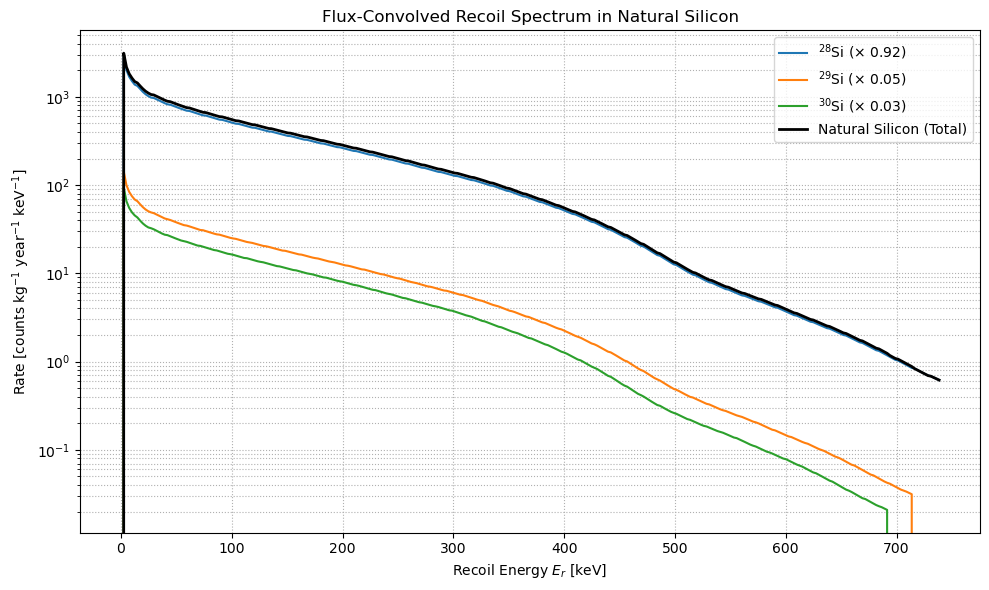

In [9]:
plt.figure(figsize=(10, 6))

# Pre-warm all splines before entering integration
print(">>> Warming up all Si isotope splines...")
for A in si_isotopes:
    try:
        test = dsigdErNE(1e3, 5.0, A)  # En=1 MeV, Er=5 keV
        print(f"    Si-{A}: OK, dsigdErNE = {test:.3e}")
    except Exception as e:
        print(f"    !! Si-{A}: spline preload failed: {e}")


for A, abundance in si_isotopes.items():
    er, spectrum = get_recoil_spectrum(A)  # This triggers printout
    if common_erange is None:
        common_erange = er  # use this spectrum’s erange as the common one
        combined_spectrum = np.zeros_like(common_erange)
    interp_spec = np.interp(common_erange, er, spectrum, left=0, right=0)
    weighted_spec = interp_spec * abundance
    interp_spectra[A] = weighted_spec
    combined_spectrum += weighted_spec
    plt.plot(common_erange, weighted_spec, label=f"$^{{{A}}}$Si (× {abundance:.2f})")

plt.plot(common_erange, combined_spectrum, label='Natural Silicon (Total)', color='black', linewidth=2)

plt.yscale('log')
plt.xlabel('Recoil Energy $E_r$ [keV]')
plt.ylabel('Rate [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
plt.title('Flux-Convolved Recoil Spectrum in Natural Silicon')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

Plot Interpretation
-
Our plot shows the total recoil energy spectrum (in DRU) for natural silicon. Our X-axis (Recoil Energy $E_r$) tells us how much energy a silicon nucleus recoils with after a neutron collides with it. Our Y-axis (Rate) tells us how frequently such recoils happen in a detector, measured in counts per kg per year per keV.

There are four curves on our plot - three for each individual Silicon isotope, and one for the total weighted isotopic combination of natural silicon. For each line, we can see that lower-energy recoils are much more frequent due to both the differential cross section often favoring small-angle scattering and lower-energy neutrons being more abundant in the flux spectrum. This also explains why each curve drops toward higher-energy recoils. Each recoil spectrum sharply reduces to a rate of 0 at around 21 KeV, indicating the point at which the maximum possible recoil energy is reached.

During elastic scattering, an incident neutron will transfer less energy to a more massive nucleus. Thus, isotopes of larger nuclei will be less likely to have larger recoil energies, which is why the curves of the heavier Silicon isotopes are shifted lower on our plot. The relatively large abundance of the Silicon-28 isotope in natural Silicon (over 92%) gives said isotope a much stronger weight in the total weighted isotopic combination of natural silicon, which is why the corresponding curve matches that of the Silicon-28 curve so closely.